# Basic example cytometry workflow

Import the cytoflow module.  We currently depend on Eugene Yurtsev's 
FlowCytometryTools for basic import functionality; this may change in
the future.

In [1]:
import cytoflow as flow
import FlowCytometryTools as fc
import numpy as np
%matplotlib inline

Read in two example files.

In [2]:
tube1 = fc.FCMeasurement(ID='Test 1', 
                       datafile='../../cytoflow/tests/data/Plate01/RFP_Well_A3.fcs')

tube2 = fc.FCMeasurement(ID='Test 2', 
                       datafile='../../cytoflow/tests/data/Plate01/CFP_Well_A4.fcs')

Create an `Experiment`.  Define an experimental condition (the amount
of Dox inducer) and add the two tubes we just imported, specifying their
experimental conditions in a `dict`.

In [3]:
ex = flow.Experiment()
ex.add_conditions({"Dox" : "float"})

ex.add_tube(tube1, {"Dox" : 10.0})
ex.add_tube(tube2, {"Dox" : 1.0})

hlog = flow.HlogTransformOp()
hlog.name = "Hlog transformation"
hlog.channels = ['V2-A', 'Y2-A', 'B1-A']
ex2 = hlog.apply(ex)

thresh = flow.ThresholdOp()
thresh.name = "Y2-A+"
thresh.channel = 'Y2-A'
thresh.threshold = 2005.0

ex3 = thresh.apply(ex2)

Have a quick look at the experiment.  Instantiate a `View` and tell it which channel
we're looking at.  The `huefacet` trait says 'plot each `Dox` condition a different color on 
the same axes.'

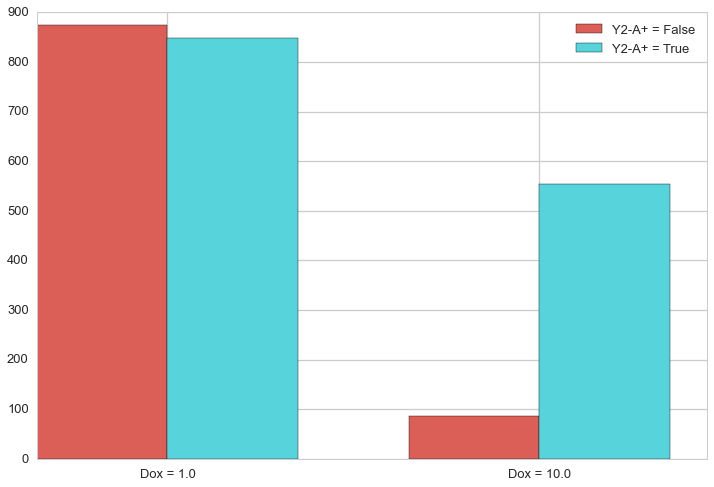

In [4]:
s = flow.BarChartView()
s.channel = "V2-A"
s.function = np.mean
s.group = "Dox"
s.subgroup = "Y2-A+"
s.plot(ex3)

Alternately, we could have the view plot the two conditions side-by-side.

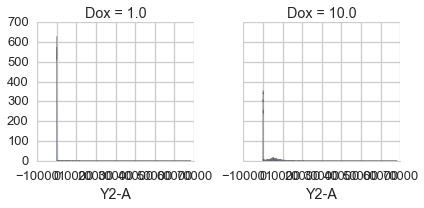

In [7]:
hist2 = flow.HistogramView()
hist2.name = "Histogram view, side-by-side"
hist2.channel = 'Y2-A'
hist2.xfacet = 'Dox'
hist2.plot(ex)

Because this is untransformed data, comparing these distributions is difficult.
Let's do an HLog transformation to make them easier to visualize.

In [9]:
hlog = flow.HlogTransformOp()
hlog.name = "Hlog transformation"
hlog.channels = ['V2-A', 'Y2-A', 'B1-A']
ex2 = hlog.apply(ex)

Note that an operation's `apply()` method takes an `Experiment` as a parameter and returns
an `Experiment`.  The latter is derived from the former; it maintains the same metadata, but
with transformed data.  *The operation is not performed in place.*  This is the beginning of
the **workflow** concept, which sees more full realization in the GUI.

Also note that both the semantics of the histogram view and the hlog operation: they are parameterized separately from the `Experiment` they're operating on.  So, we can just reuse a pre-existing `HistogramView` instance to view the new `Experiment` instance that the hlog operation gave us.

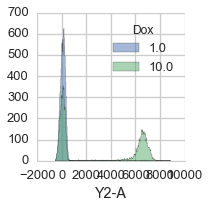

In [10]:
hist.plot(ex2)

Now we can see a clear difference between the two tubes: one has a large population > 2000 in the Y2-A channel (transformed value), and the other tube doesn't.  Let's create a threshold gate to separate the populations.

One more important semantic note.  A gate *does not remove events; it simply adds additional
metadata to the events already there.*  You can get at an `Experiment`'s underlying pandas dataframe by looking at the Experiment.data trait and verifying that all three `Experiments` we've created have the same number of events.

In [9]:
print ex.data.shape
print ex2.data.shape
print ex3.data.shape

(20000, 17)
(20000, 17)
(20000, 18)


The last experiment, though, has another column named 'Y2-A+', which is whether each event ended up above the threshold or not.

In [10]:
print ex.data.columns
print ex2.data.columns
print ex3.data.columns

Index([u'B1-A', u'B1-H', u'B1-W', u'Dox', u'FSC-A', u'FSC-H', u'FSC-W', u'HDR-T', u'SSC-A', u'SSC-H', u'SSC-W', u'V2-A', u'V2-H', u'V2-W', u'Y2-A', u'Y2-H', u'Y2-W'], dtype='object')
Index([u'B1-A', u'B1-H', u'B1-W', u'Dox', u'FSC-A', u'FSC-H', u'FSC-W', u'HDR-T', u'SSC-A', u'SSC-H', u'SSC-W', u'V2-A', u'V2-H', u'V2-W', u'Y2-A', u'Y2-H', u'Y2-W'], dtype='object')
Index([u'B1-A', u'B1-H', u'B1-W', u'Dox', u'FSC-A', u'FSC-H', u'FSC-W', u'HDR-T', u'SSC-A', u'SSC-H', u'SSC-W', u'V2-A', u'V2-H', u'V2-W', u'Y2-A', u'Y2-H', u'Y2-W', u'Y2-A+'], dtype='object')


Now we can plot using that additional piece of metadata....

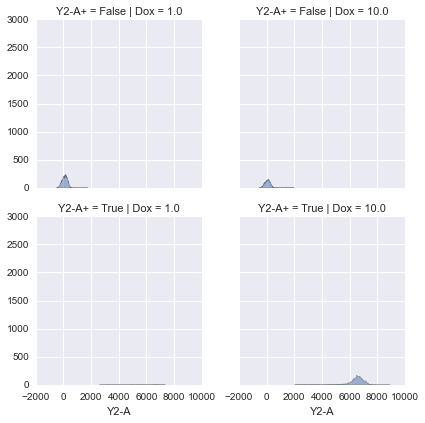

In [11]:
hist3 = flow.HistogramView()
hist3.name = "Histogram view, grid"
hist3.channel = 'Y2-A'
hist3.xfacet = 'Dox'
hist3.yfacet = 'Y2-A+'
hist3.plot(ex3)

....or we can ask "how many events were above the threshold?"   Eventually this will be a statistics view, like a bar chart, or a summary table.  For now, we use the pandas API to answer the question.

In [13]:
import numpy as np
ex3.data.groupby(['Dox', 'Y2-A+']).size()

Dox  Y2-A+
1    False    9953
     True       47
10   False    5610
     True     4390
dtype: int64

I hope this makes the semantics of the cytoflow package clear.  I'm pretty married to them, because I think they support the right combination of ease of use for interactive work and power for scripting/integration into larger programs (like the accompanying GUI.)